#### Wide Ranging Days
+ Strategy taken from Jack Schwager's book a _Complete Guide to the Futures Market_
+ Wide-ranging day: Day on which _volatility ratio_ (VR) is greater than some value k
+ _Volatility ratio_ is equalt to today's true range divided by the average true range of past N days
+ _True range_ is the difference between the true high and the true low
+ _True High_ is the max between todays high and yesterdays close
+ _True Low_ is the min between todays low and yesterdays close
+ _Price Trigger Range_: Range defined by interval between highest true high and lowest true low in the interval between N1 days before most recent wide-ranging day and N2 after most-recent wide-ranging day. 
+ _Price Trigger Range_ is redefine on each wide ranging day and will apply to the subsequent wide ranging day

#### Why this could work
+ Days with high volatility mark extremes of market sentiment
+ If in subsequent days, the market can push through and sustain price levels beyond the boundaries of the previous volatile extremes it may signal a new trend is established

#### Strategy
+ On a close above the high of the PTR, reverse from short to long
+ On a close below the low of PTR, reverse from long to short


#### Daily Checklist
+ If short and today's close is above the high of the PTR, liquidate short and go long
+ If long and today's close is below the low of the PTR, liquidate long and go short
+ Check if N2 days have passed since the most recent wide-ranging day, if so redefine the _Price Trigger Range_

#### System Parameters
+ _N1_ number of days prior to wide ranging day included in the PTR period
+ _N2_ number of days after the wide ranging day included in the PTR period
+ _k_ volatility ratio must be exceeded in order to redefine the a wide-ranging day

In [2]:
from math import floor
import datetime as datetime
import quandl as ql
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'


In [285]:
def compute_true_range(df):
    '''
    Computes and sets the true range of between today and yesterday
    
    
    Parameters
    ==========
    ds: xr.Dataset of price time series
    
    Return 
    ======
    true_range: pd.DataFrame
    
    '''
    
    true_range = df.copy()
    possible_highs = pd.concat([df['Close'].shift(-1), df['High']],axis=1)
    true_range['true_high'] = np.max(possible_highs,axis=1)
        
    possible_lows = pd.concat([df['Low'],df['Close'].shift(-1)],axis=1)
    true_range['true_low'] = np.max(possible_lows, axis=1)
    true_range['true_range'] = true_range['true_high'] - true_range['true_low']
    return true_range

def compute_wide_ranging_day(df, N, k):
    '''
    
    '''
    
    df_new = compute_true_range(df)
    
    volatility_ratio = df_new['true_range']/df_new['true_range'].rolling(N).mean()
    
    df_new['wide_ranging_day'] = np.where(df_new['true_range'] > k, 1,0)
    
    return df_new


def compute_price_trigger_range(df, N1, N2):
    '''
    Trigger Range is range defined by highest true high and lowest true low for window 
    N1 days before and N2 days after last wide ranging day
    
    '''
    
    new_df = df.copy()
    new_df['price_trigger_high'] = 0.
    new_df['price_trigger_low'] = 0.
    for i in range(len(df)):
        if new_df.iloc[[i - N2]]['wide_ranging_day'].values == 1.0:
                idx = new_df.iloc[[i-N2]].index.values[0]
                hth = new_df[i - (N1 + N2):i].true_high.max()
                ltl = new_df[i - (N1 + N2):i].true_low.min()

                new_df.loc[idx, 'price_trigger_high'] = hth
                new_df.loc[idx, 'price_trigger_low'] = ltl
                
#     new_df = new_df.fillna(Nan)          
    return new_df

def define_positions(range_df):
    
    range_copy = range_df.copy()
#     print(ctd_copy.columns)
    range_copy['position'] = np.where(range_copy['Close'] >= range_copy['price_trigger_high'], 1, 0)
    range_copy['position'] = np.where(range_copy['Close'] <= range_copy['price_trigger_low'], -1, range_copy['position'])
    
    return range_copy


def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]

    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals).astype(np.int), signals.index)

In [271]:
copper_futures = ql.get('CHRIS/MCX_CU1', api_key='YgkL6nxrm_SsUs7so2MM')

In [315]:
copper_futures.head()

,Open,High,Low,Close,Volume,Open Interest
Date,,,,,,
2013-12-03,445.60,445.6,445.60,445.6,23956.0,13220.0
2013-12-04,446.25,451.2,443.70,445.5,37562.0,14320.0
2013-12-05,450.00,450.0,446.05,451.3,27406.0,13867.0
2013-12-06,447.00,451.4,445.35,447.1,35756.0,13202.0
2013-12-07,447.10,447.1,447.10,447.1,35756.0,13202.0


In [316]:
range_df = compute_wide_ranging_day(copper_futures, 10, 2)
trigger_range = compute_price_trigger_range(range_df,3, 3)
ctd_copy = define_positions(trigger_range)



In [317]:
ctd_copy['return'] = np.log(ctd_copy['Close']/ctd_copy['Close'].shift(1))

In [318]:
ctd_copy['strategy'] = ctd_copy['return']*ctd_copy['position']

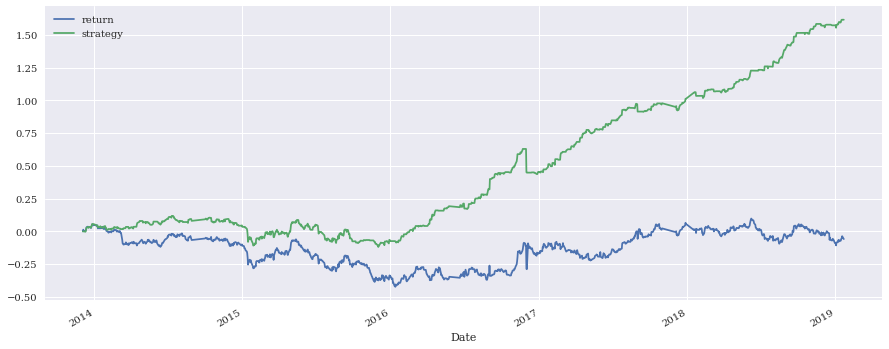

In [319]:
ctd_copy[['return','strategy']].cumsum().plot(figsize=(15, 6));

#### Next Steps
+ Run this in a proper backtesting, event based approach that moves forward in time
+ Add functionality to test different parameters to find our what values of N1, N2 and k are best